In [1]:
from numpy.random.bit_generator import SeedlessSeedSequence
import tensorflow as tf
import os
import numpy as np
import random
from sklearn.utils import shuffle
#from tqdm import tqdm #Provides a progress bar while the images are being resized
from skimage.io import imshow, imread
from skimage.transform import resize
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tifffile as tiff
from keras.models import Model
from keras.optimizers import Adam
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
from patchify import patchify
from sklearn.metrics import jaccard_score,  accuracy_score, f1_score, make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import random
#%load_ext tensorboard
from keras import backend as K
seed =42
np.random.seed=42
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from PIL import Image, ImageEnhance
from spectral import *

In [2]:
HEIGHT = 512
WIDTH = 512
CHANNELS = 10

In [3]:
X=[]
y=[]

for a in range(1,36):
  Xpath = '/Users/anshugusain/tf-nuclei/content/Stained-40X/Field' + str(a) + '/cube_envi32.hdr'
  Ximg = spectral.open_image(Xpath)
  #Field = Ximg.read_bands((45,63,85,100,110))
  Field = Ximg.read_bands((45,46,88,97,98,102,119,122,123,136))
  #Field = Ximg.read_bands((180,210,220,230,240,250,260,270,280,290,300,310,320,330,340))

  ypath = '/Users/anshugusain/tf-nuclei/content/Stained-40X/Field' + str(a) + '/Field' + str(a) + '-mask.tif'
  yimg = tf.keras.preprocessing.image.load_img(ypath, grayscale=True)


  Xpatches = patchify(Field,(HEIGHT,WIDTH,CHANNELS),step=HEIGHT)

  yimg = np.asarray(yimg)
  ypatches = patchify(yimg, (HEIGHT,WIDTH), step=HEIGHT)

  for m in range(0, Xpatches.shape[0]):
    for l in range(0, Xpatches.shape[1]):
      X.append(Xpatches[m,l,0])
      y.append(ypatches[m,l])

X = np.array(X)
y = np.array(y)
X = X.astype("float64")
y = y.astype('float64')


/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [4]:
X = X/X.max()
y = y/y.max()

In [5]:
X.max()

1.0

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y ,random_state=42, test_size=0.2, shuffle=True)

In [7]:
X_train = np.expand_dims(X_train,-1)
#X_train = np.expand_dims(X_train,0)
y_train = np.expand_dims(y_train,-1)

In [8]:
HEIGHT = 512
WIDTH = 512
CHANNELS = 10

In [9]:
X_train.shape, y_train.shape, X_train.dtype

((28, 512, 512, 10, 1), (28, 512, 512, 1), dtype('float64'))

In [10]:
IMG_HEIGHT = HEIGHT
IMG_WIDTH = WIDTH
IMG_CHANNELS = CHANNELS


inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,1))
#s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
s = inputs

#Contraction path
c1 = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.2)(c1)
c1 = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling3D((2,2,2))(c1)

c2 = tf.keras.layers.Conv3D(64, (3, 3,3), activation='relu', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv3D(64, (3, 3,3), activation='relu', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling3D((2, 2,2))(c2)

c3 = tf.keras.layers.Conv3D(128, (3, 3,3), activation='relu', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv3D(128, (3, 3,3), activation='relu', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling3D((2, 2,2))(c3)

c4 = tf.keras.layers.Conv3D(256, (3, 3,3), activation='relu', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(c4)


flat6 = Flatten()(c4)
output_1 = Dense(8, activation='sigmoid', name='output_1')(flat6)


#Expansive path
u6 = tf.keras.layers.Conv3DTranspose(128, (2,2,2), strides=(2, 2,2), padding='same')(c4)
u6 = tf.keras.layers.concatenate([u6, c3], axis =3)
c6 = tf.keras.layers.Conv3D(128, (3,3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv3D(128, (3, 3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv3DTranspose(64, (2,2,2), strides=(2, 2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c2], axis =3)
c7 = tf.keras.layers.Conv3D(64, (3, 3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv3D(64, (3, 3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv3DTranspose(32, (2, 2,2), strides=(2, 2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c1], axis =3)
c8 = tf.keras.layers.Conv3D(32, (3, 3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv3D(32, (3, 3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

"""
u9 = tf.keras.layers.Conv3DTranspose(16, (2, 2,2), strides=(2, 2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv3D(16, (3, 3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv3D(16, (3, 3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
"""

conv3d_shape = c8.shape

c8 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(c8)

output_2 = Conv2D(1, (1, 1), activation='sigmoid', name='output_2')(c8)

model = Model(inputs=[inputs], outputs=[ output_2])

model.compile(optimizer=tf.keras.optimizers.legacy.SGD(), loss=['binary_crossentropy'], metrics=['accuracy'])

2023-07-12 12:48:37.057203: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-12 12:48:37.057224: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
filepath="/Users/anshugusain/tf-nuclei/Models/best_weights.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_jacard_coef', verbose=1,save_best_only=True, mode='max')

callbacks_list = [checkpoint]

results = model.fit(X_train, y_train, batch_size = 1, steps_per_epoch = 1, epochs=200, shuffle=False, validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/200


2023-07-12 12:48:37.492630: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-12 12:48:37.877639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 1.2947 - accuracy: 3.3951e-04

2023-07-12 12:54:30.700046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 394s 394s/step - loss: 1.2947 - accuracy: 3.3951e-04 - val_loss: 0.5328 - val_accuracy: 0.8642
Epoch 2/200


1/1 [==============================] - 4s 4s/step


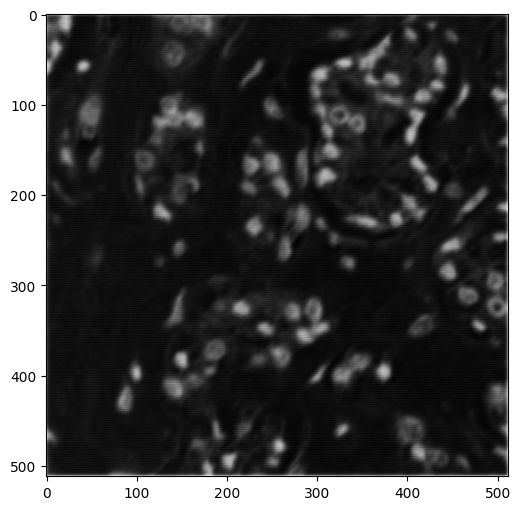

In [18]:
test_predict = model.predict(np.expand_dims(X_test[0],0))
test_predict = np.asarray(test_predict)
plt.figure(figsize=(10,6))
plt.imshow(test_predict.squeeze(),cmap='gray')

In [ ]:
test_predict.max()  

In [ ]:
print(history.history.keys())

In [ ]:
plt.plot(history.history['mean_io_u_9'])
plt.title('model IoU')
plt.ylabel('IoU')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
def average_calc(X_examine, y_examine):
  IoUs = [len(X_examine)]
  total =0
  average =0

  for i in range(0,len(X_examine)):
    test_predict = model.predict(np.expand_dims(X_examine[i],0))
    test_predict = np.asarray(test_predict) 
    IoU = jaccard_score((test_predict>0.1).squeeze(), (y_examine[i]>0).squeeze(), average='micro')
    total =IoU + total
  average = total / len(X_examine)
  
  return average

In [20]:
average_calc(X_test, y_test)

1/1 [==============================] - 4s 4s/step


0.5505695151966116

In [7]:
model = tf.keras.models.load_model('/Users/anshugusain/tf-nuclei/Models/HYPERNET.h5')

In [27]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)

1/1 - 5s - loss: 0.3027 - mean_io_u_1: 0.4351 - 5s/epoch - 5s/step


In [28]:
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

Untrained model, accuracy: 43.51%


In [32]:
conv11.shape

TensorShape([None, 144, 144, 3584])